# Simulations

## Simple simulations

First, we consider the case where we get an immediate boost in productivity when we either relax or take a 1-hour nap.

In [1]:
using Distributed
using ProgressMeter
using POMDPs, Pkg
using Distributions
using Parameters

struct SleepState
    complete::Int32
    productivity::Int32
    deadline::Int32
end

@with_kw mutable struct SleepPOMDP <: POMDP{SleepState, Symbol, Float64}
    r_complete::Int32 = 10000
    r_missed::Int32 = -100
    sleep_multiplier::Float64 = 2.5
    work_multiplier::Float64 = 0.9
    relax_multiplier::Float64 = 1.2
    max_deadline::Int32 = 7
    discount::Float64 = 1.0
    obs_sigma::Float64 = 0.0
end

SleepPOMDP

In [2]:
using POMDPModelTools
using Random
function POMDPs.states(m::SleepPOMDP)
    return vec(collect(SleepState(complete, productivity, deadline) for complete in range(1, 100), productivity in range(1, 100), deadline in range(1, 12)))
end

function POMDPs.n_states(m::SleepPOMDP)
    return 100 * 100 * 12
end

function POMDPs.stateindex(m::SleepPOMDP, s::SleepState)
    return s.complete * 100 * 12 + s.productivity * 12 + s.deadline
end

function POMDPs.actions(m::SleepPOMDP)
    return [:work, :sleep, :relax]
end

function POMDPs.actionindex(m::SleepPOMDP, a::Symbol)
    if a == :work
        return 1
    elseif a == :sleep
        return 2
    elseif a == :relax
        return 3
    end
    error("Invalid Action $a")
end

function POMDPs.reward(m::SleepPOMDP, s::SleepState, a::Symbol)
    if s.deadline == 0 && s.complete < 100
        return -100
    elseif s.complete == 100
        return 100
    elseif a == :relax
        return 1
    else
        return 0
    end
end

function POMDPs.transition(m::SleepPOMDP, s::SleepState, a::Symbol)
    deadline = s.deadline - 1
    complete = s.complete
    productivity = s.productivity
    if s.deadline == 0 || s.complete == 100
        complete = 0
        deadline = 12
    end

    if a == :work
        if s.complete < 100
            complete = round(s.complete + 20 * (s.productivity / 100))
        end
        productivity = round(s.productivity * m.work_multiplier)
    elseif a == :sleep
        productivity = min(round(s.productivity * m.sleep_multiplier), 100)
    else
        productivity = min(round(s.productivity * m.relax_multiplier), 100)
    end
    return Deterministic(SleepState(complete, productivity, deadline))
end

function POMDPs.observation(m::SleepPOMDP, a::Symbol, sp::SleepState)
    return Normal(sp.complete, 10)
end

function POMDPs.discount(m::SleepPOMDP)
    return 0.95
end

POMDPs.initialstate_distribution(m::SleepPOMDP) = Deterministic(SleepState(0, 100, 12))


In [66]:
using POMDPSimulators
using POMDPPolicies
m = SleepPOMDP()
policy = RandomPolicy(m)
hr = HistoryRecorder(max_steps=5*12)
history = simulate(hr, m, policy)
discounted_reward(history)
# for (s, a, r, o) in stepthrough(m, policy, "s,a,r,o", max_steps=10)
#     @show s
#     @show a
#     @show r
#     println()
# end

-97.52142923167246

In [67]:
m = SleepPOMDP()
policy = FunctionPolicy(o->:work)
hr = HistoryRecorder(max_steps=5*12)
history = simulate(hr, m, policy)
discounted_reward(history)

-49.28830409810858

In [21]:
using PyPlot
pygui(:qt5)
function sleep_plot(history, path)
    complete = []
    productivity = []
    deadline = []
    observation = []
    actions = []
    i = 0
    for (s, a, o, r) in eachstep(history, "s,a,o,r")
        push!(complete, s.complete)
        push!(productivity, s.productivity)
        push!(deadline, s.deadline)
        push!(observation, o)
        push!(actions, a)
    end
    figure(figsize=(8, 8))
    plot(collect(1:length(complete)), complete, color="green")
    plot(collect(1:length(productivity)), productivity, color="orange")
    plot(collect(1:length(deadline)), deadline, color="red")
    prev = 1
    curr = 1
    curr_seg_action = ""
    # actions = fill(:work, length(actions))
    push!(actions, :end)
    linewidth = 7.0
    for action in actions
        if action != curr_seg_action
            if curr_seg_action == :work
                axvspan(prev, curr, 0, 100, color="black", alpha=.2)
            elseif curr_seg_action == :relax
                axvspan(prev, curr, 0, 100, color="pink", alpha=.2)
            else
                axvspan(prev, curr, 0, 100, color="blue", alpha=.2)
            end
            prev = curr
            curr_seg_action = action
        end
        curr += 1
    end
    savefig(path)
end

┌ Warning: PyPlot is using tkagg backend, which is known to cause crashes on MacOS (#410); use the MPLBACKEND environment variable to request a different backend.
└ @ PyPlot /Users/haojun/.julia/packages/PyPlot/4wzW1/src/init.jl:192


sleep_plot (generic function with 1 method)

In [63]:
using ParticleFilters
using BasicPOMCP
using ARDESPOT
problem = SleepPOMDP()
solver = DESPOTSolver(bounds=(DefaultPolicyLB(RandomSolver()), 2000))
planner = solve(solver, problem)
filter = SIRParticleFilter(problem, 1000)
hr = HistoryRecorder(max_steps=5*12)
history = simulate(hr, m, planner, filter)
discounted_reward(history)
# for (s,a,r,sp,o) in stepthrough(problem, planner, filter, "s,a,r,sp,o", max_steps=2*24)
#     @show (s,a,r,sp,o)
# end

157.2862135126599

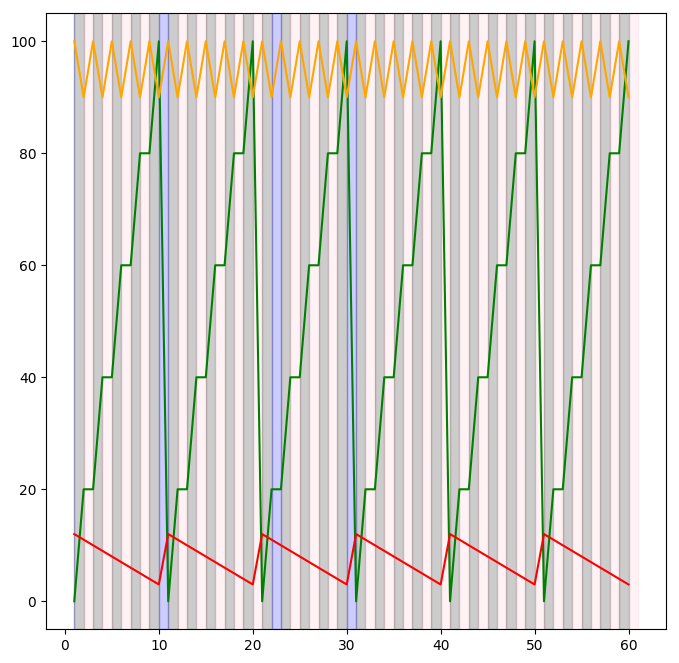

In [64]:
sleep_plot(history, "optimal_immediate_boost.png")

We see that the optimal strategy is to work for an hour and relax for an hour and then work for an hour, etc. This is intuitive because we would like to keep ourselves at top productivity so long as we have not yet exceeded our deadline.

## 

In [49]:
using POMDPs, Pkg
using Distributions
using Parameters

struct SleepState2
    complete::Int32
    productivity::Int32
    deadline::Int32
    hours_slept::Int32
end

@with_kw mutable struct SleepPOMDP2 <: POMDP{SleepState2, Symbol, Float64}
    r_complete::Int32 = 10000
    r_missed::Int32 = -100
    sleep_multiplier::Float64 = 2.5
    work_multiplier::Float64 = 0.9
    relax_multiplier::Float64 = 1.2
    max_deadline::Int32 = 24
    discount::Float64 = 1.0
    obs_sigma::Float64 = 0.0
end

SleepPOMDP2

In [77]:
using POMDPModelTools
using Random
function POMDPs.states(m::SleepPOMDP2)
    return vec(collect(SleepState(complete, productivity, deadline, hours_slept) for complete in range(1, 100), productivity in range(1, 100), deadline in range(0, m.max_deadline), hours_slept in range(0, 24)))
end

function POMDPs.n_states(m::SleepPOMDP2)
    return 100 * 100 * (m.max_deadline + 1) * (24 + 1)
end

function POMDPs.stateindex(m::SleepPOMDP2, s::SleepState2)
    return (s.complete - 1) * 100 * (m.max_deadline + 1) * 25 + (s.productivity - 1) * (m.max_deadline + 1) * 25 + s.deadline * 25 + s.hours_slept + 1
end

function POMDPs.actions(m::SleepPOMDP2)
    return [:work, :sleep, :relax]
end

function POMDPs.actionindex(m::SleepPOMDP2, a::Symbol)
    if a == :work
        return 1
    elseif a == :sleep
        return 2
    elseif a == :relax
        return 3
    end
    error("Invalid Action $a")
end

function POMDPs.reward(m::SleepPOMDP2, s::SleepState2, a::Symbol)
    if s.deadline == 0 && s.complete < 100
        return -100
    elseif s.complete > 100
        return 100
    elseif a == :relax
        return 1
    else
        return 0
    end
end

function POMDPs.transition(m::SleepPOMDP2, s::SleepState2, a::Symbol)
    deadline = s.deadline - 1
    complete = s.complete
    productivity = s.productivity
    if s.deadline == 0 || s.complete > 100
        complete = 0
        deadline = m.max_deadline
    end

    if a == :work
        if s.complete < 100 && s.deadline > 0
            complete = round(s.complete + 15 * (s.productivity / 100))
        end
        productivity = round(s.productivity * m.work_multiplier)
        hours_slept = 0
    elseif a == :sleep
        if s.hours_slept >= 3
            productivity = min(round(s.productivity * m.sleep_multiplier), 100)
        end
        hours_slept = s.hours_slept + 1
    else
        if productivity < 50
            productivity = min(round(s.productivity * m.relax_multiplier), 100)
        end
        hours_slept = s.hours_slept
    end
    return Deterministic(SleepState2(complete, productivity, deadline, hours_slept))
end

function POMDPs.observation(m::SleepPOMDP2, a::Symbol, sp::SleepState2)
    return Truncated(Normal(sp.complete, 10), 0.0, Inf)
end

function POMDPs.discount(m::SleepPOMDP2)
    return 0.95
end

POMDPs.initialstate_distribution(m::SleepPOMDP2) = Deterministic(SleepState2(0, 100, m.max_deadline, 0))


In [78]:
using POMDPSimulators
using POMDPPolicies
m = SleepPOMDP2()
policy = RandomPolicy(m)
simulate(RolloutSimulator(max_steps=5*12), m, policy)

-12.07605848041539

In [79]:
m = SleepPOMDP2()
policy = FunctionPolicy(o->:work)
hr = HistoryRecorder(max_steps=5*12)
history = simulate(hr, m, policy)
discounted_reward(history)

41.10208774882328

In [80]:
using ParticleFilters
using BasicPOMCP
using ARDESPOT
problem = SleepPOMDP2()
solver = DESPOTSolver(bounds=(DefaultPolicyLB(RandomSolver()), 2000))
planner = solve(solver, problem)
filter = SIRParticleFilter(problem, 1000)
hr = HistoryRecorder(max_steps=5*12)
history = simulate(hr, problem, planner, filter)
discounted_reward(history)

┌ Warning: DESPOT's MemorizingSource random number generator had to move the memory locations of the rngs 15064 times. If this number was large, it may be affecting performance (profiling is the best way to tell).
│ 
│ To suppress this warning, use MemorizingSource(..., move_warning=false).
│ 
│ To reduce the number of moves, try using MemorizingSource(..., min_reserve=n) and increase n until the number of moves is low (the final min_reserve was 8).
└ @ ARDESPOT /Users/haojun/.julia/packages/ARDESPOT/5VlKW/src/random_2.jl:96


102.33804021823374

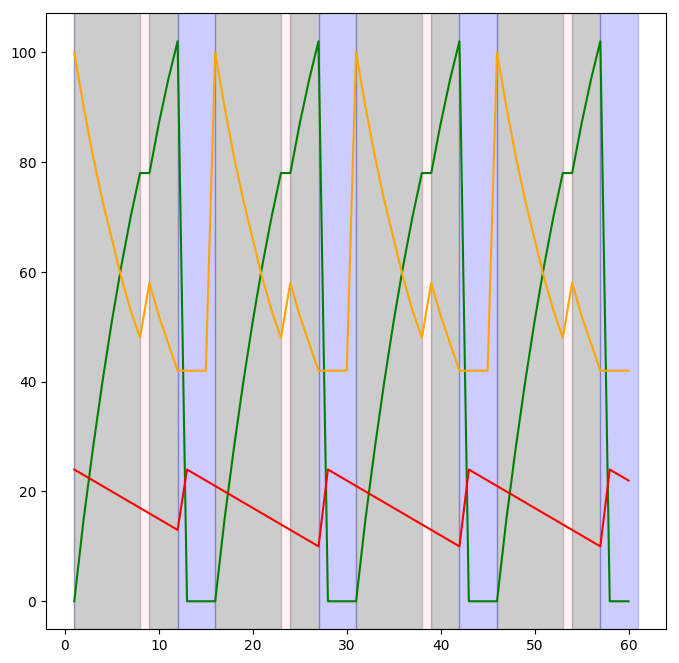

In [81]:
sleep_plot(history, "optimal_productivity_thresh.png")

We can see that the strategy is what we would expect, basically work as much as possible until we believe that our productivity is lower than a threshold, then we either sleep for 4 hours or relax for an hour. Then, we keep working until we are done. Interestingly we almost always sleep or relax on the hour that we are finished. This is probably because of the way we defined the reward function is that we only collect reward after we have finished the assignment regardless of the action we took at that time. Thus, we can maximize our productivity by resting on the hour when we finish rather than immediately working

## Randomness in Transitions

So far we have explored deterministic transitions. Now is the time to explore random transitions

In [102]:
using POMDPs, Pkg
using Distributions
using Parameters

struct SleepState3
    complete::Int32
    productivity::Int32
    deadline::Int32
    hours_slept::Int32
    hours_since_slept::Int32
end

@with_kw mutable struct SleepPOMDP3 <: POMDP{SleepState3, Symbol, Float64}
    r_complete::Int32 = 10000
    r_missed::Int32 = -100
    sleep_multiplier::Float64 = 1.5
    work_multiplier::Float64 = 0.8
    relax_multiplier::Float64 = 1.2
    max_deadline::Int32 = 72
    discount::Float64 = 1.0
    obs_sigma::Float64 = 10
end

SleepPOMDP3

In [108]:
using POMDPModelTools
using Random
# function POMDPs.states(m::SleepPOMDP)
#     return vec(collect(SleepState(complete, productivity, deadline, hours_slept) for complete in range(1, 100), productivity in range(1, 100), deadline in range(0, m.max_deadline), hours_slept in range(0, 24)))
# end

# function POMDPs.n_states(m::SleepPOMDP)
#     return 100 * 100 * (m.max_deadline + 1) * (24 + 1)
# end

# function POMDPs.stateindex(m::SleepPOMDP, s::SleepState)
#     return (s.complete - 1) * 100 * (m.max_deadline + 1) * 25 + (s.productivity - 1) * (m.max_deadline + 1) * 25 + s.deadline * 25 + s.hours_slept + 1
# end

function POMDPs.actions(m::SleepPOMDP3)
    return [:work, :sleep, :relax]
end

function POMDPs.actionindex(m::SleepPOMDP3, a::Symbol)
    if a == :work
        return 1
    elseif a == :sleep
        return 2
    elseif a == :relax
        return 3
    end
    error("Invalid Action $a")
end

function POMDPs.reward(m::SleepPOMDP3, s::SleepState3, a::Symbol)
    if s.deadline == 0 && s.complete < 100
        return -100
    elseif s.complete >= 100
        return 100
    elseif a == :relax && s.hours_since_slept < 12
        return 1
    else
        return 0
    end
end

function POMDPs.gen(m::SleepPOMDP3, s::SleepState3, a::Symbol, rng::AbstractRNG)
    deadline = s.deadline - 1
    complete = s.complete
    productivity = s.productivity
    hours_since_slept = s.hours_since_slept + 1
    hours_slept = 0
    if s.deadline == 0 || s.complete >= 100
        complete = 0
        deadline = round(rand(rng, Truncated(Normal(m.max_deadline, 5), 0.0, m.max_deadline)))
    end

    if a == :work
        if s.complete < 100 && s.deadline > 0
            complete = round(s.complete + rand(rng, Truncated(Normal(10 * (s.productivity / 100), 1), 0.0, Inf)))
        end
        productivity = round(s.productivity * rand(rng, Normal(m.work_multiplier, 0.01)))
    elseif a == :sleep
        if s.hours_slept >= 6
            productivity = min(round(s.productivity * rand(rng, Normal(m.sleep_multiplier, 0.01))), 100)
            hours_since_slept = 0
        end
        hours_slept = s.hours_slept + 1
    else
        if s.hours_since_slept < 12
            productivity = min(round(s.productivity * rand(rng, Normal(m.relax_multiplier, 0.01))), 100)
        end
    end
    return (sp=SleepState3(complete, productivity, deadline, hours_slept, hours_since_slept),)
end

function POMDPs.observation(m::SleepPOMDP3, a::Symbol, sp::SleepState3)
    return Truncated(Normal(sp.complete, m.obs_sigma), 0.0, Inf)
end

function POMDPs.discount(m::SleepPOMDP3)
    return 0.95
end

POMDPs.initialstate_distribution(m::SleepPOMDP3) = Deterministic(SleepState3(0, 100, m.max_deadline, 0, 0))


In [109]:
using POMDPSimulators
using POMDPPolicies
m = SleepPOMDP3()
policy = RandomPolicy(m)
simulate(RolloutSimulator(max_steps=15*12), m, policy)

-0.3361256970676943

In [110]:
using POMDPSimulators
using POMDPPolicies
m = SleepPOMDP3()
policy = FunctionPolicy(o->:work)
simulate(RolloutSimulator(max_steps=15*12), m, policy)

4.009582408726599

In [111]:
using ParticleFilters
using BasicPOMCP
using ARDESPOT
problem = SleepPOMDP3()
solver = DESPOTSolver(bounds=(DefaultPolicyLB(RandomSolver()), 2000))
planner = solve(solver, problem)
filter = SIRParticleFilter(problem, 1000)
hr = HistoryRecorder(max_steps=15*12)
history = simulate(hr, problem, planner, filter)
discounted_reward(history)

┌ Warning: DESPOT's MemorizingSource random number generator had to move the memory locations of the rngs 36111 times. If this number was large, it may be affecting performance (profiling is the best way to tell).
│ 
│ To suppress this warning, use MemorizingSource(..., move_warning=false).
│ 
│ To reduce the number of moves, try using MemorizingSource(..., min_reserve=n) and increase n until the number of moves is low (the final min_reserve was 16).
└ @ ARDESPOT /Users/haojun/.julia/packages/ARDESPOT/5VlKW/src/random_2.jl:96


23.188169190868127

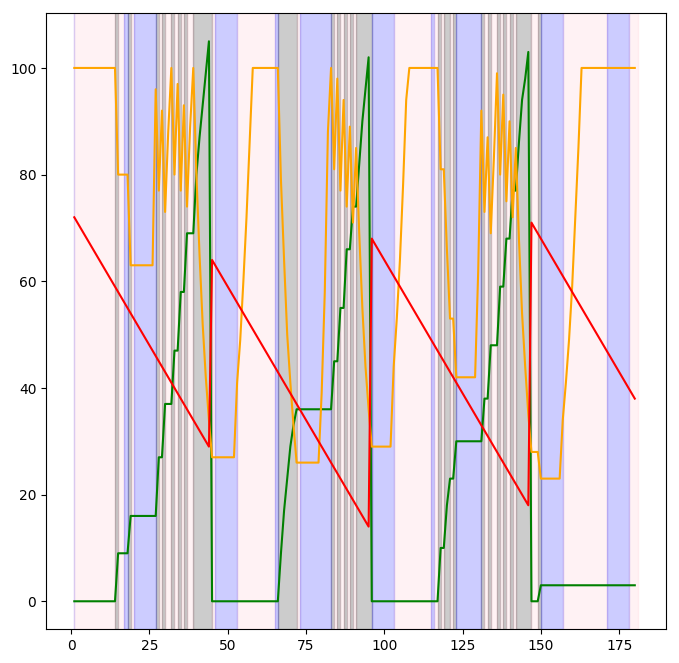

In [112]:
sleep_plot(history, "optimal_more_complex.png")

## Impossible Workload

In [117]:
problem = SleepPOMDP3(work_multiplier=0.9, max_deadline=25)
policy = RandomPolicy(m)
simulate(RolloutSimulator(max_steps=20*12), m, policy)

1.3584843908720459

In [118]:
problem = SleepPOMDP3(work_multiplier=0.9, max_deadline=25)
policy = FunctionPolicy(o->:work)
simulate(RolloutSimulator(max_steps=20*12), m, policy)

2.411132871886497

In [121]:
using ParticleFilters
using BasicPOMCP
using ARDESPOT
solver = DESPOTSolver(bounds=(DefaultPolicyLB(RandomSolver()), 2000))
planner = solve(solver, problem)
filter = SIRParticleFilter(problem, 1000)
hr = HistoryRecorder(max_steps=15*12)
history = simulate(hr, problem, planner, filter)
discounted_reward(history)

┌ Warning: DESPOT's MemorizingSource random number generator had to move the memory locations of the rngs 37573 times. If this number was large, it may be affecting performance (profiling is the best way to tell).
│ 
│ To suppress this warning, use MemorizingSource(..., move_warning=false).
│ 
│ To reduce the number of moves, try using MemorizingSource(..., min_reserve=n) and increase n until the number of moves is low (the final min_reserve was 14).
└ @ ARDESPOT /Users/haojun/.julia/packages/ARDESPOT/5VlKW/src/random_2.jl:96


29.586738975452427

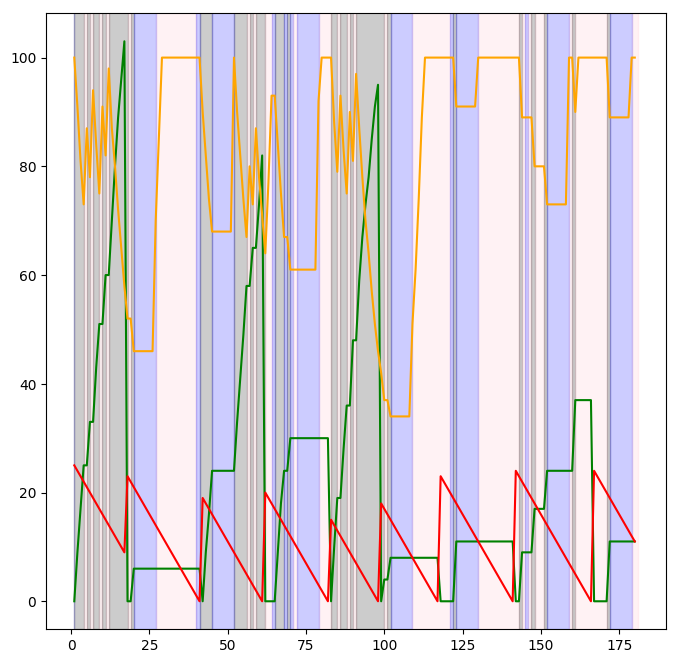

In [122]:
sleep_plot(history, "optimal_impossible.png")